In [119]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from numpy.random import rand
from numpy import typing as npt
from typing import Optional, Counter
import random
from dataclasses import dataclass

# Linear-systematische Blockcodes
## 1. Einleitung
In der Vorlesung wurde die Fehlererkennung und -korrektur mit Hilfe von linear-
systematischen Blockcodes vorgestellt. In dieser Laborübung soll die Anwendung von
Kanalcodierung in Python umgesetzt werden. Eine erste Simulation einer digitalen
Übertragunsstrecke soll implementiert und erste Simulationen durchgeführt werden.

## 2. Implementieren in Python
Implementieren Sie eine Python-Klasse `BlockCode` mit den Attributen:
- `k`: Anzahl Nutzbits
- `n`: Anzahl Codebits
- `p`: Anzahl Prüfbits
- `max_corr_bits`: maximale Anzahl korrigierter Bits (bis zu zwei soll unterstützt werden)
- `G`: Generatormatrix
- `P`: Teil-Matrix
- `H`: Kontrollmatrix
- `S`: Syndrom-Tabelle

und den Methoden:
- `codeword = encode(message)`
- `message, corrected_errors = decode(codeword)`
  - Eine Korrektur soll nur bei einem eindeutigen Fehlersyndrom mit maximal zwei Fehlern durgeführt werden
  - Rückgabewerte: korrigierte Nachricht, Anzahl korrigierter Fehler (0-2)
    - falls keine Korrektur durchgeführt werden kann, wird statt der korrigierten Nachricht `None` zurückgegeben

Beim Konstruktor wird die Matrix `P` sowie `max_corr_bits`, die Obergrenze der korrigierbaren
Bitfehler übergeben. Die übrigen Attribute können aus den Argumenten bestimmt werden. Bei
der Syndrom-Tabelle ist es nicht notwendig, eine allgemeine Variante zu implementieren. Es
genügt, die Syndrom-Tabelle für einen oder zwei korrigierbare Fehler zu implementieren.

<small>Tipp 1: Verwenden Sie bei der Implementierung Arrays (Matrizen, Vektor) aus dem Modul
numpy und verwenden Sie Matrix-Multiplikationen (Funtion `numpy.matmul`).</small>

<small>Tipp 2: Binären Vektor (Array) in Integerwert umwandeln:
`int(''.join([f'{b}' for b in v]),2)`</small>

In [120]:
NPRNG = np.random.Generator(np.random.PCG64(123456789))

class BlockCode:
    def __init__(self, P: npt.ArrayLike, max_corr_bits = 0):
        self.P = np.array(P, dtype=int)
        self.max_corr_bits = max_corr_bits
        self.k = self.P.shape[0]
        self.p = self.P.shape[1]
        self.n = self.k + self.p
        self.G = np.hstack((np.eye(self.k, dtype=int), self.P))
        self.H = np.hstack((self.P.T, np.eye(self.p, dtype=int)))
        self.S = self._generate_syndrome_table()

    def _generate_syndrome_table(self):
        syndrome_table = {}

        if self.max_corr_bits == 0:
            return syndrome_table
        
        for error_bits in range(1, self.max_corr_bits + 1):
            for error_positions in itertools.combinations(range(self.n), error_bits):
                error_vector = np.zeros(self.n, dtype=int)
                for pos in error_positions:
                    error_vector[pos] = 1
                syndrome = tuple(np.matmul(self.H, error_vector) % 2)

                if not np.any(syndrome):
                    continue

                if syndrome not in syndrome_table:
                    syndrome_table[syndrome] = []

                is_duplicate = False
                for existing_vector in syndrome_table[syndrome]:
                    if np.array_equal(existing_vector, error_vector):
                        is_duplicate = True
                        break
                if not is_duplicate:
                    syndrome_table[syndrome].append(error_vector)

        final_syndrome_table = {}
        for syndrome, error_vectors in syndrome_table.items():
            if len(error_vectors) == 1:
                final_syndrome_table[syndrome] = error_vectors[0]
        return syndrome_table

    def encode(self, message: str) -> npt.NDArray:
        message = np.array(message)
        if len(message) != self.k:
            raise ValueError("Message length must be equal to k")
        codeword = np.matmul(message, self.G) % 2
        return codeword

    def decode(self, codeword: npt.NDArray) -> tuple[Optional[npt.NDArray], int]:
        codeword = np.array(codeword)
        if len(codeword) != self.n:
            raise ValueError(f"Codeword length must be equal to n={self.n}, got {len(codeword)}")
            
        syndrome = tuple(np.matmul(self.H, codeword) % 2)

        # No errors detected
        if not any(syndrome):
            message = codeword[:self.k]
            return message, 0

        # Error detected, try to correct if in syndrome table
        if syndrome in self.S and len(self.S[syndrome]) == 1:
            error_vector = self.S[syndrome][0]  # Get the first (and only) error vector
            num_errors = np.sum(error_vector)
            if num_errors <= self.max_corr_bits:
                corrected_codeword = (codeword + error_vector) % 2
                message = corrected_codeword[:self.k]
                return message, int(num_errors)
                
        # Cannot correct: syndrome not found or ambiguous
        return None, 0
        
# TEST:
blockcode = BlockCode([[1, 0, 1], [0, 1, 1], [1, 1, 0]], max_corr_bits=2)
message = NPRNG.integers(0, 2, size=blockcode.k)
codeword = blockcode.encode(message)
decoded_message, corrected_errors = blockcode.decode(codeword)
assert np.array_equal(message, decoded_message), "Decoded message does not match original message"

## 3. Bitfehler / Kanalmodell
Implementieren Sie zwei Modelle, um Bitfehler zu erzeugen:
1. ein binär-symmetrischen Kanal (BSC), der jedes Bit unabhängig mit Wahrscheinlichkeit `p` umkippt.\
    <small>Tipp: `rand()` aus `numpy.random`</small>
2. ein Kanal mit fester Anzahl Bitfehler pro Codewort, die an zufälligen Stellen auftreten.\
    <small>Tipp 1: `sample(rand(n))` mit `sample` aus `random` liefert Bitpositionen</small>\
    <small>Tipp 2: Funktion `flipbits(bit_vector, position_list)` ist hilfreich</small>

Die Kanalmodell sollen als Klassen implementiert werden. Die Übertragung eines Pakets (das
Einfügen der Bitfehler) soll durch Überladen der Methode `__call__` erfolgen, so dass Sie die
Übertragung durch `y = Channel(x)` durchführen können, wobei `Channel` ein Objekt eines
Kanalmodells ist, `x` die gesendete und `y` die empfangene Nachricht. Nachrichten sind jeweils
binäre Vektoren (`numpy.array`).

In [121]:
class BinarySymmetricChannel:
    def __init__(self, p: float):
        if not (0 <= p <= 1):
            raise ValueError("Probability p must be between 0 and 1")
        self.p = p

    def __call__(self, bit_vector: npt.NDArray) -> npt.NDArray:
        noise = rand(len(bit_vector)) < self.p
        return (bit_vector + noise.astype(int)) % 2


class FixedErrorChannel:
    def __init__(self, num_errors: int):
        if num_errors < 0:
            raise ValueError("Number of errors must be non-negative")
        self.num_errors = num_errors

    def __call__(self, bit_vector: npt.NDArray) -> npt.NDArray:
        if self.num_errors > len(bit_vector):
            raise ValueError("Number of errors cannot exceed the length of the bit vector")
        error_positions = random.sample(range(len(bit_vector)), self.num_errors)
        return self.flipbits(bit_vector, error_positions)

    @staticmethod
    def flipbits(bit_vector: npt.NDArray, position_list: list[int]) -> npt.NDArray:
        flipped_vector = bit_vector.copy()
        for pos in position_list:
            flipped_vector[pos] = 1 - flipped_vector[pos]
        return flipped_vector


## 4. Test
Testen Sie ihre Implementierung mit den Codes aus der Vorlesung:
1. der Matrix `P` des `(7,4)-Codes` aus der Vorlesung mit `max_corr_bits = 1`
2. mit `P = [[1, 0], [1, 0], [1, 1], [1, 1], [0, 1], [0, 1]]` und `max_corr_bits = 2`
3. mit `P = [[1, 0, 1], [1, 0, 0], [1, 1, 1], [1, 1, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1]]` und `max_corr_bits = 2`

Verwenden Sie das Bitmodell mit der festen Fehlerzahl, um die Anzahl korrigierbarer Bits zu
überprüfen.

In [122]:
MATRIX1 = np.array([[1, 0, 1, 1], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
MATRIX2 = np.array([[1, 0], [1, 0], [1, 1], [1, 1], [0, 1], [0, 1]])
MATRIX3 = np.array([[1, 0, 1], [1, 0, 0], [1, 1, 1], [1, 1, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1]])

TEST_MATRICES = [
    (MATRIX1, 1),
    (MATRIX2, 2),
    (MATRIX3, 2),
]

for errors in range(4):
    for i, (matrix, max_corr_bits) in enumerate(TEST_MATRICES):
        print(f"Testing with error count: {errors} and matrix: MATRIX{i + 1}")
        code = BlockCode(matrix, max_corr_bits)
        channel = FixedErrorChannel(errors)
        message = NPRNG.integers(0, 2, size=code.k, dtype=int)
        codeword = code.encode(message)
        print(f"Original message: {message}, Codeword: {codeword}")
        
        received_codeword = channel(codeword)
        print(f"Received codeword: {received_codeword}")
        
        decoded_message, corrected_errors = code.decode(received_codeword)
        print(f"Decoded message: {decoded_message}, Corrected errors: {corrected_errors}\n")

        if errors <= max_corr_bits:
            if np.array_equal(decoded_message, message):
                print("Test passed!\n")
            else:
                print("Test failed: Decoded message does not match original message\n")
        else:
            if decoded_message is not codeword:
                print("Test passed: Decoding failed as expected\n")
            else:
                print("Test failed: Decoding should have failed but succeeded\n")
        print("-" * 50)

Testing with error count: 0 and matrix: MATRIX1
Original message: [1 0 1 0 1 0 1], Codeword: [1 0 1 0 1 0 1 1 0 0 1]
Received codeword: [1 0 1 0 1 0 1 1 0 0 1]
Decoded message: [1 0 1 0 1 0 1], Corrected errors: 0

Test passed!

--------------------------------------------------
Testing with error count: 0 and matrix: MATRIX2
Original message: [0 1 0 1 0 0], Codeword: [0 1 0 1 0 0 0 1]
Received codeword: [0 1 0 1 0 0 0 1]
Decoded message: [0 1 0 1 0 0], Corrected errors: 0

Test passed!

--------------------------------------------------
Testing with error count: 0 and matrix: MATRIX3
Original message: [0 1 1 1 1 1 0], Codeword: [0 1 1 1 1 1 0 1 0 0]
Received codeword: [0 1 1 1 1 1 0 1 0 0]
Decoded message: [0 1 1 1 1 1 0], Corrected errors: 0

Test passed!

--------------------------------------------------
Testing with error count: 1 and matrix: MATRIX1
Original message: [0 1 0 0 0 1 1], Codeword: [0 1 0 0 0 1 1 1 1 0 1]
Received codeword: [0 1 0 0 1 1 1 1 1 0 1]
Decoded message: Non

## 5. Simulationsstudie
### 5.1 Übertragung einer Nachricht
Implementieren Sie die Simulation der Übertragung einer Nachricht über eine digitale
Übertragungsstrecke, die folgende Komponenten beinhaltet:
1. **Quelle**: Erzeugung einer zufälligen Nachricht aus `k` Bits.
2. **Kanalcodierung** (Sender): Codieren sie die Nachricht mit einem linear-systematischen Code.
3. **Übertragungskanal**: Simulieren sie die Übertragung der Nachricht, in dem Sie mit einem Kanalmodell Bitfehler hinzufügen.
4. **Kanalcodierung** (Empfänger): Dekodieren/korrigieren Sie die Nachricht am Empfänger.
5. **Auswertung**: Bestimmen Sie,
    1. die Anzahl der Bitfehler vor der Korrektur
    2. ob eine Fehlerkorrektur durchgeführt wurde (ob Fehlersyndrom in Syndrom-Tabelle enthalten ist)
    3. die Anhahl korrigierter Bits
    4. die Anzahl der Bitfehler im Codewort nach der Korrektur

<small>
Tipp: Implementieren Sie alle Elemente der Übertragungsstrecke so, dass sie mit der <code>__call__</code>
Funktion aufgerufen werden können. Für den BlockCode bedeutet das, dass es eine Klasse
Encoder und eine Klasse Decoder gibt, die z.B. als Attribut die gleiche Instanz der Klasse
BlockCode haben
</small>

In [123]:
class Encoder:
    def __init__(self, block_code: BlockCode):
        self.block_code = block_code

    def __call__(self, message: str) -> npt.NDArray:
        return self.block_code.encode(message)
    
class Decoder:
    def __init__(self, block_code: BlockCode):
        self.block_code = block_code

    def __call__(self, codeword: npt.NDArray) -> tuple[Optional[npt.NDArray], int]:
        return self.block_code.decode(codeword)
    
class Channel:
    def __init__(self, channel_type: str, param: float):
        if channel_type == "bsc":
            self.channel = BinarySymmetricChannel(param)
        elif channel_type == "fec":
            self.channel = FixedErrorChannel(int(param))
        else:
            raise ValueError("Invalid channel type. Use 'bsc' or 'fec'.")

    def __call__(self, bit_vector: npt.NDArray) -> npt.NDArray:
        return self.channel(bit_vector)

### 5.2 Simulationsstudie
In der Simulationsstudie sollen N Nachrichten übertragen werden und dann eine statistische
Auswertung mit den folgenden Ergebnissen durchgeführt werden:
1. Anzahl/Anteil fehlerfrei übertragener Nachrichten
2. Anzahl/Anteil korrigierter Nachrichten
3. Anzahl/Anteil fehlerbehafteter aber nicht korrigierter Nachrichten (zu viele Bitfehler, Fehlersyndrom
    nicht in der Syndrom-Tabelle enthalten)
4. Anzahl/Anteil erfolgreich korrigierter Nachrichten (Bitfehler vorhanden und erfolgreich korrigiert)
5. Anzahl/Anteil fehlerhaft korrigierter Nachrichten (Bitfehler nach der Korrektur noch vorhanden)
6. die Verteilung der Anzahl Bitfehler vor der Korrektur (als Counter)
7. die Verteilung der Anzahl korrigierter Bits (als Counter)
8. die Verteilung der Anzahl Bitfehler nach der Korrektur (als Counter)

In [124]:
@dataclass
class SimulationResult:
    num_correct: int
    num_corrected: int
    num_wrong_uncorrected: int
    num_correct_corrected: int
    num_wrong_corrected: int
    errors_before: Counter[int]
    corrected_bits: Counter[int]
    errors_after: Counter[int]

def studie(block_code: BlockCode, channel: Channel, encoder: Encoder, decoder: Decoder, num_trials: int = 1000) -> SimulationResult:
    num_correct = 0
    num_corrected = 0
    num_wrong_uncorrected = 0
    num_correct_corrected = 0
    num_wrong_corrected = 0
    errors_before = Counter[int]()
    corrected_bits = Counter[int]()
    errors_after = Counter[int]()
    
    for _ in range(num_trials):
        message = NPRNG.integers(0, 2, size=block_code.k, dtype=int)
        codeword = encoder(message)
        received_codeword = channel(codeword)
        decoded_message, corrected_errors = decoder(received_codeword)
        error_count = int(np.sum(received_codeword != codeword))
        errors_before[error_count] += 1
        corrected_bits[corrected_errors] += 1
        if decoded_message is not None:
            # print(f"Original message:\t{message}\nDecoded message:\t{decoded_message}\n")
            error_count = int(np.sum(message != decoded_message))
            errors_after[error_count] += 1

        if np.array_equal(message, decoded_message):
            num_correct += 1
            if corrected_errors > 0:
                num_corrected += 1
                num_correct_corrected += 1
        elif corrected_errors > 0:
            num_corrected += 1
            num_wrong_corrected += 1
        else:
            num_wrong_uncorrected += 1
    
    return SimulationResult(
        num_correct=num_correct,
        num_corrected=num_corrected,
        num_wrong_uncorrected=num_wrong_uncorrected,
        num_correct_corrected=num_correct_corrected,
        num_wrong_corrected=num_wrong_corrected,
        errors_before=errors_before,
        corrected_bits=corrected_bits,
        errors_after=errors_after
    )
    

### 5.3 Szenario 1
Betrachten Sie den (7,4)-Hamming-Code mit maximal einem Koorigierten Bitfehler. Die Nachrichten werden über einen 
binär-symmetrischen Kanal mit einer Bitfehlerwahrscheinlichkeit von 5% übertragen.

C:\Users\Fabian\AppData\Local\Temp\ipykernel_24908\3628563003.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Fabian\AppData\Local\Temp\ipykernel_24908\3628563003.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


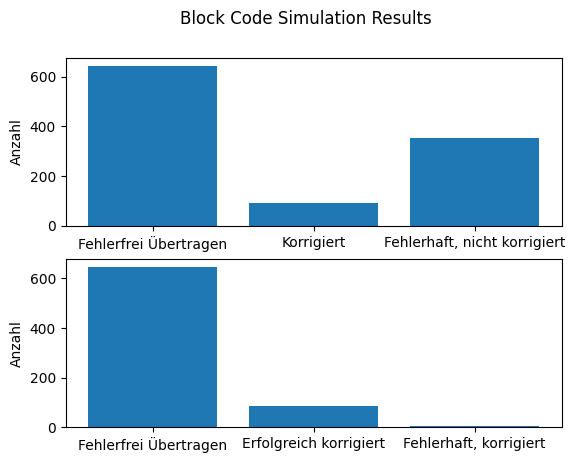

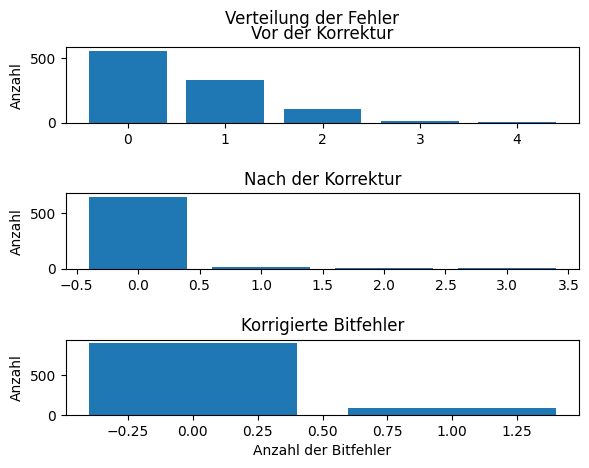

In [125]:
# (7,4)-Hamming-Code := MATRIX1

N = 1000
block_code = BlockCode(MATRIX1, max_corr_bits=1)
encoder = Encoder(block_code)
decoder = Decoder(block_code)
channel = Channel("bsc", 0.05)

result1 = studie(block_code, channel, encoder, decoder, N)
    
fig, ax = plt.subplots(2,1)
fig.suptitle("Block Code Simulation Results")
ax[0].bar(["Fehlerfrei Übertragen", "Korrigiert", "Fehlerhaft, nicht korrigiert"], [result1.num_correct, result1.num_corrected, result1.num_wrong_uncorrected])
ax[0].set_ylabel("Anzahl")


ax[1].bar(["Fehlerfrei Übertragen", "Erfolgreich korrigiert", "Fehlerhaft, korrigiert"], [result1.num_correct, result1.num_correct_corrected, result1.num_wrong_corrected])
ax[1].set_ylabel("Anzahl")

fig.show()

fig, ax = plt.subplots(3, 1)
fig.tight_layout(pad=3.0)
fig.suptitle("Verteilung der Fehler")
ax[0].bar(result1.errors_before.keys(), result1.errors_before.values())
ax[0].set_title("Vor der Korrektur")
ax[0].set_ylabel("Anzahl")
ax[1].bar(result1.errors_after.keys(), result1.errors_after.values())
ax[1].set_title("Nach der Korrektur")
ax[1].set_ylabel("Anzahl")
ax[2].bar(result1.corrected_bits.keys(), result1.corrected_bits.values())
ax[2].set_title("Korrigierte Bitfehler")
ax[2].set_xlabel("Anzahl der Bitfehler")
ax[2].set_ylabel("Anzahl")

fig.show()

### 5.4 Szenario 2
Betrachten Sie den Code mit `P` = `MATRIX3` und `max_corr_bits=2`. Die Nachrichten
werden über einen binär-symmetrischen Kanal mit einer Bitfehlerwahrscheinlichkeit von 15%
übertragen. Erstellen Sie die gleichen Grafiken wie in der vorigen Aufgabe.

C:\Users\Fabian\AppData\Local\Temp\ipykernel_24908\1492416227.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Fabian\AppData\Local\Temp\ipykernel_24908\1492416227.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


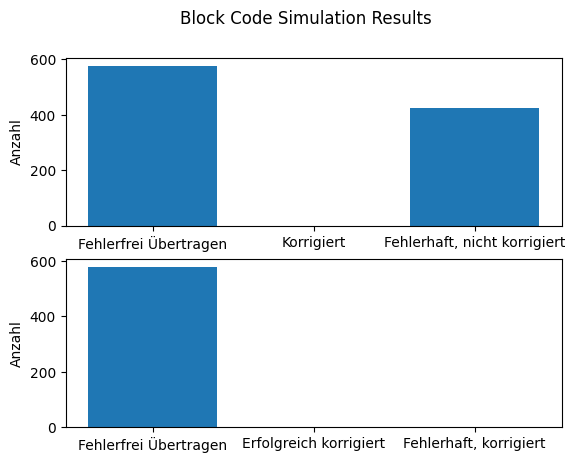

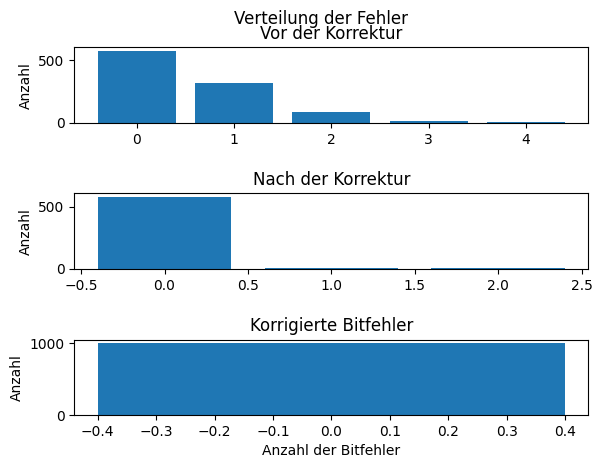

In [126]:
block_code = BlockCode(MATRIX3, max_corr_bits=2)
encoder = Encoder(block_code)
decoder = Decoder(block_code)
channel = Channel("bsc", 0.05)

result2 = studie(block_code, channel, encoder, decoder, N)
    
fig, ax = plt.subplots(2,1)
fig.suptitle("Block Code Simulation Results")
ax[0].bar(["Fehlerfrei Übertragen", "Korrigiert", "Fehlerhaft, nicht korrigiert"], [result2.num_correct, result2.num_corrected, result2.num_wrong_uncorrected])
ax[0].set_ylabel("Anzahl")


ax[1].bar(["Fehlerfrei Übertragen", "Erfolgreich korrigiert", "Fehlerhaft, korrigiert"], [result2.num_correct, result2.num_correct_corrected, result2.num_wrong_corrected])
ax[1].set_ylabel("Anzahl")

fig.show()

fig, ax = plt.subplots(3, 1)
fig.tight_layout(pad=3.0)
fig.suptitle("Verteilung der Fehler")
ax[0].bar(result2.errors_before.keys(), result2.errors_before.values())
ax[0].set_title("Vor der Korrektur")
ax[0].set_ylabel("Anzahl")
ax[1].bar(result2.errors_after.keys(), result2.errors_after.values())
ax[1].set_title("Nach der Korrektur")
ax[1].set_ylabel("Anzahl")
ax[2].bar(result2.corrected_bits.keys(), result2.corrected_bits.values())
ax[2].set_title("Korrigierte Bitfehler")
ax[2].set_xlabel("Anzahl der Bitfehler")
ax[2].set_ylabel("Anzahl")

fig.show()

### 5.5 Scenario 3
Untersuchen Sie jetzt den Einfluss der Bitfehlerwahrscheinlichkeit. Führen Sie Simulationen mit
je 1000 Nachrichten und selbstgewählten Bitfehlerwahrscheinlichkeiten zwischen 0,1% bis 20%
durch. Vergleichen Sie die Restfehlerwahrscheinlichkeit für die Code mit den Matrizen (7,4)-
Hamming-Code, den (11,4)-Hamming-Code. Bei letzterem Code sollen bis zu zwei Bitfehler korrigiert
werden.

In [127]:
MATRIX4 = np.array([[1, 0, 1, 0], [1, 0, 0, 1], [1, 1, 1, 0], [1, 1, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]])

block_code74 = BlockCode(MATRIX1, max_corr_bits=1)
encoder74 = Encoder(block_code74)
decoder74 = Decoder(block_code74)

block_code114 = BlockCode(MATRIX4, max_corr_bits=2)
encoder114 = Encoder(block_code114)
decoder114 = Decoder(block_code114)

# channel = Channel("bsc", 0.10)


error_probabilities = [0.01, 0.05, 0.10, 0.15, 0.20]
for error_probability in error_probabilities:
    channel = Channel("bsc", error_probability)
    error_count74 = 0
    error_count114 = 0
    for _ in range(N):
        message = NPRNG.integers(0, 2, size=block_code74.k, dtype=int)
        codeword74 = encoder74(message)
        codeword114 = encoder114(message)
        received_codeword74 = channel(codeword74)
        received_codeword114 = channel(codeword114)
        decoded_message74, corrected_errors74 = decoder74(received_codeword74)
        decoded_message114, corrected_errors114 = decoder114(received_codeword114)
        error_count74 += int(np.array_equal(decoded_message74, message) == False)
        error_count114 += int(np.array_equal(decoded_message114, message) == False)

    print(f"Bitfehlerwahrscheinliochkeit: {error_probability*100:.0f}%")
    print(f"Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: {error_count74/N*100:.2f}%")
    print(f"Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: {error_count114/N*100:.2f}%\n")

Bitfehlerwahrscheinliochkeit: 1%
Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: 6.40%
Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: 11.40%

Bitfehlerwahrscheinliochkeit: 5%
Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: 36.00%
Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: 42.20%

Bitfehlerwahrscheinliochkeit: 10%
Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: 56.40%
Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: 68.30%

Bitfehlerwahrscheinliochkeit: 15%
Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: 73.70%
Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: 82.50%

Bitfehlerwahrscheinliochkeit: 20%
Restfehlerwahrscheinlichkeit für (7,4)-Hamming-Code: 85.80%
Restfehlerwahrscheinlichkeit für (11,4)-Hamming-Code: 90.40%

